<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/ML_CAMPANELLA_E4_ML_DL_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Percorso del file
file_path = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CAMPANELLA FILE PKL/TEST LABEL #1/CAMPANELLAETAL_E4_45SEC_750L.csv"

# Carica il dataset
df = pd.read_csv(file_path)

# Mostra info di base
print("Shape del dataset:", df.shape)
df.head()

Shape del dataset: (5197, 21)


,HRV_MeanNN,HRV_MedianNN,HRV_MadNN,HRV_IQRNN,HRV_Prc20NN,HRV_pNN50,HRV_HTI,HRV_MFDFA_alpha1_Peak,HRV_FuzzyEn,HRV_LZC,...,PPG_Duration,label,subject,protocol_phase,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,AccMag_Mean,AccMag_Std,AccMag_IQR,AccMag_Skew
0,851.409314,796.8750,254.821875,328.12500,593.750,88.235294,8.500000,0.834876,1.259909,1.223464,...,0.904622,0,subject_01,rest_1,10.0,0.474759,65.811918,2.140918,1.452823,0.297350
1,784.319196,796.8750,254.821875,285.15625,578.125,75.000000,9.333333,1.227469,1.403198,1.140730,...,0.844651,0,subject_01,rest_1,9.0,0.049423,66.139587,1.372693,0.748424,0.292738
2,811.631944,804.6875,312.735937,386.71875,556.250,77.777778,18.000000,1.287490,1.402623,1.172292,...,0.874081,0,subject_01,rest_1,9.0,0.047288,66.020477,1.456172,0.850274,0.447230
3,791.294643,773.4375,277.987500,355.46875,546.875,75.000000,18.666667,1.220485,1.432742,1.037028,...,0.826946,0,subject_01,rest_1,10.0,0.072174,65.917027,1.871208,0.828314,-0.531419
4,816.550926,789.0625,254.821875,320.31250,587.500,79.629630,18.000000,0.833219,1.559117,1.065720,...,0.843149,0,subject_01,rest_1,10.0,0.077495,65.867743,1.868495,0.873714,-0.536302


In [ ]:
for col in df.columns:
  print(col)

HRV_MeanNN
HRV_MedianNN
HRV_MadNN
HRV_IQRNN
HRV_Prc20NN
HRV_pNN50
HRV_HTI
HRV_MFDFA_alpha1_Peak
HRV_FuzzyEn
HRV_LZC
PPG_Amplitude
PPG_Duration
label
subject
protocol_phase
SCR_Peaks_N
SCR_Peaks_Amplitude_Mean
AccMag_Mean
AccMag_Std
AccMag_IQR
AccMag_Skew


In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Absolut Frequency': freq_assolute,
    'Relative Frequency (%)': freq_relative.round(2)*100
})

frequency_table

,Absolut Frequency,Relative Frequency (%)
label,,
1,3457,67.0
0,1740,33.0


In [ ]:
counts = df.groupby(['subject', 'label']).size().unstack(fill_value=0)

counts['Totale'] = counts.sum(axis=1)

counts['Freq_Label_1 (%)'] = (counts[0] / counts['Totale'] * 100).round(2)
counts['Freq_Label_2 (%)'] = (counts[1] / counts['Totale'] * 100).round(2)

counts = counts.rename(columns={0: 'Baseline', 1: 'Stress'})

counts.reset_index(inplace=True)
counts

label,subject,Baseline,Stress,Totale,Freq_Label_1 (%),Freq_Label_2 (%)
0,subject_01,62,146,208,29.81,70.19
1,subject_02,60,133,193,31.09,68.91
2,subject_03,62,106,168,36.90,63.10
3,subject_04,62,109,171,36.26,63.74
4,subject_05,64,109,173,36.99,63.01
5,subject_06,61,114,175,34.86,65.14
6,subject_07,62,112,174,35.63,64.37
7,subject_08,64,121,185,34.59,65.41
8,subject_09,61,122,183,33.33,66.67
9,subject_10,62,120,182,34.07,65.93


In [ ]:
sum(df.isna().sum())

0

LOSO LOGISTIC REGRESSION

=== LOSO LOGISTIC REGRESSION ===
Samples: 5197, Features: 18, Subjects: 29

Inizio valutazione LOSO:
  Fold  1 - subject_01: F1=0.759 Acc=0.635
  Fold  2 - subject_02: F1=0.656 Acc=0.539
  Fold  3 - subject_03: F1=0.806 Acc=0.786
  Fold  4 - subject_04: F1=0.803 Acc=0.731
  Fold  5 - subject_05: F1=0.835 Acc=0.815
  Fold  6 - subject_06: F1=0.842 Acc=0.760
  Fold  7 - subject_07: F1=0.792 Acc=0.661
  Fold  8 - subject_08: F1=0.774 Acc=0.649
  Fold  9 - subject_09: F1=0.780 Acc=0.754
  Fold 10 - subject_10: F1=0.770 Acc=0.648
  Fold 11 - subject_11: F1=0.844 Acc=0.821
  Fold 12 - subject_12: F1=0.798 Acc=0.714
  Fold 13 - subject_13: F1=0.824 Acc=0.767
  Fold 14 - subject_14: F1=0.765 Acc=0.709
  Fold 15 - subject_15: F1=0.743 Acc=0.720
  Fold 16 - subject_16: F1=0.819 Acc=0.722
  Fold 17 - subject_17: F1=0.615 Acc=0.495
  Fold 18 - subject_18: F1=0.789 Acc=0.734
  Fold 19 - subject_19: F1=0.862 Acc=0.808
  Fold 20 - subject_20: F1=0.594 Acc=0.590
  Fold 21 - subject_21: F1=0.711 Acc=0.

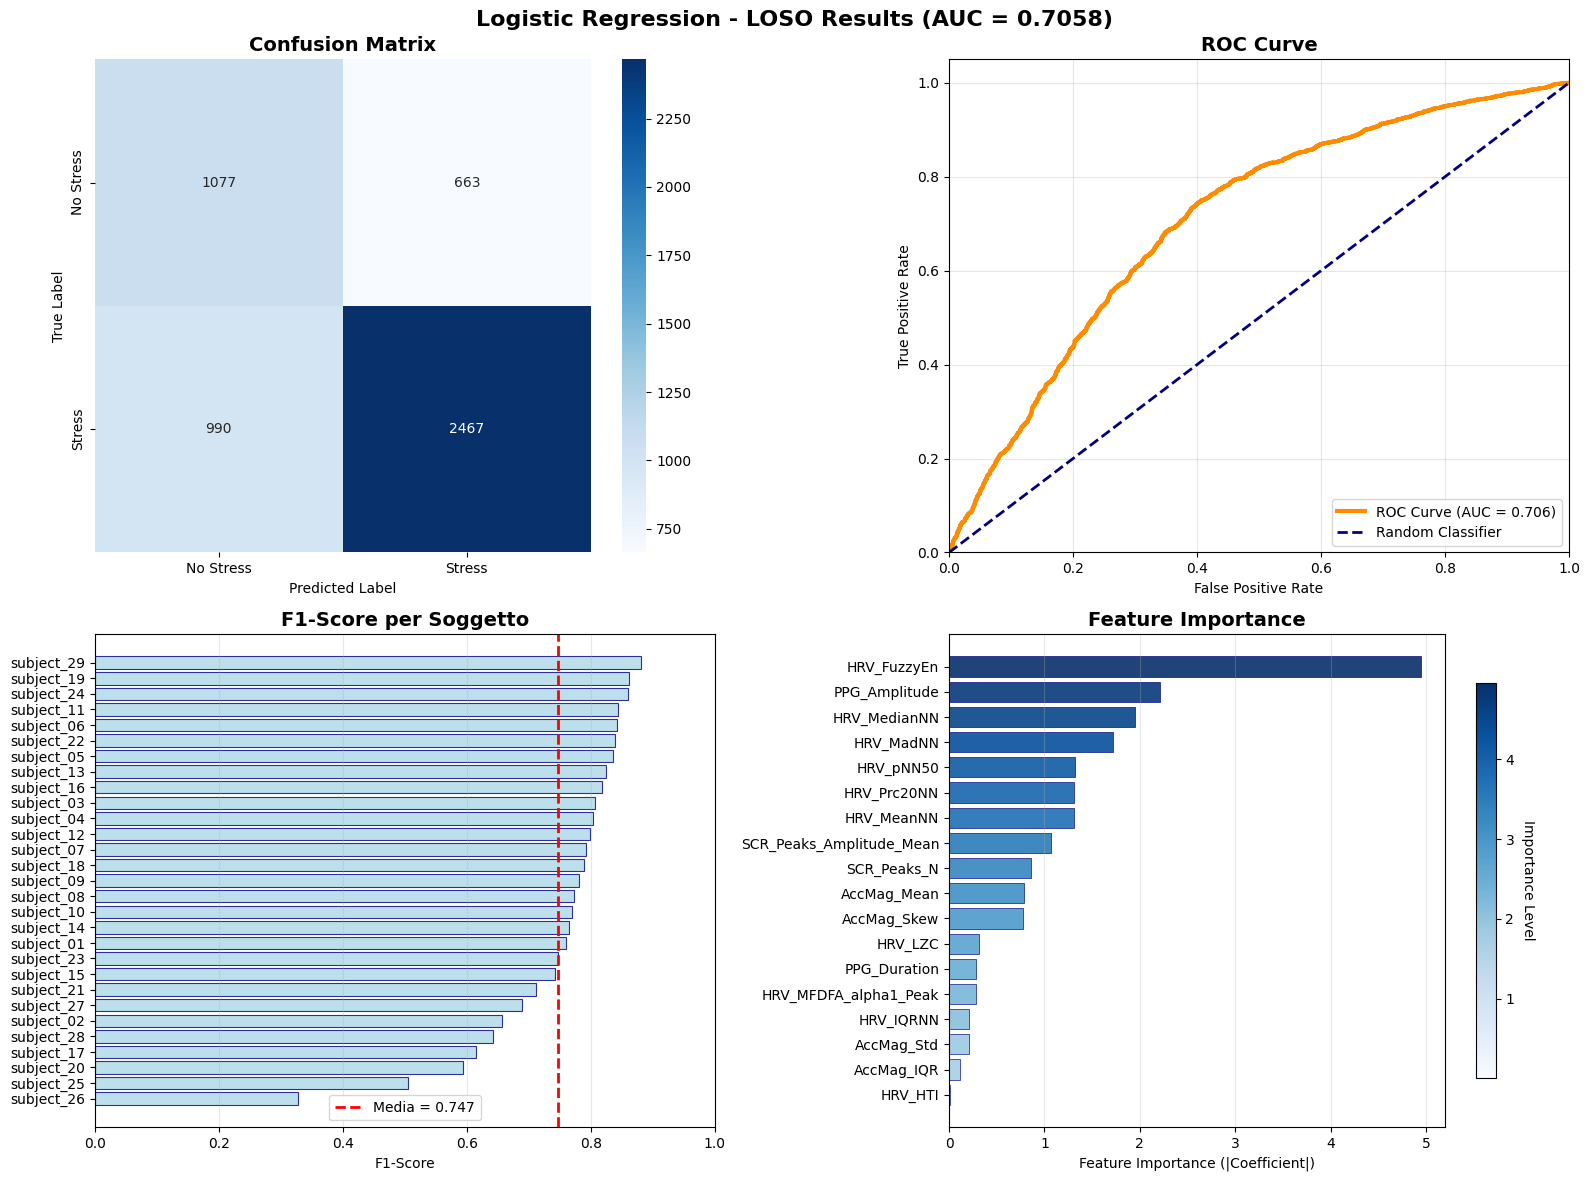


SUMMARY LOGISTIC REGRESSION LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.7473 ± 0.1201
AUC globale: 0.7058
Accuratezza globale: 0.6819
Range F1-Score: 0.3284 - 0.8814
Miglior soggetto: subject_29 (F1=0.8814)
Peggiore soggetto: subject_26 (F1=0.3284)


In [ ]:
# =============================================================================
# LOSO LOGISTIC REGRESSION CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO LOGISTIC REGRESSION ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_lr = np.array(all_y_true).copy()
all_y_pred_lr = np.array(all_y_pred).copy()
all_y_prob_lr = np.array(all_y_prob).copy()
fpr_lr, tpr_lr, _ = roc_curve(all_y_true_lr, all_y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

f1_mean_lr = results_df['f1_score'].mean()
f1_std_lr = results_df['f1_score'].std()
acc_mean_lr = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Logistic Regression - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Palette Graduale
if final_model is not None:
    # Calcola importance in valore assoluto
    coefficients = np.abs(final_model.coef_[0])

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (|Coefficient|)')
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY LOGISTIC REGRESSION LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")
print(f"{'='*60}")

RANDOM FOREST

=== LOSO RANDOM FOREST ===
Samples: 5197, Features: 18, Subjects: 29

Inizio valutazione LOSO:
  Fold  1 - subject_01: F1=0.830 Acc=0.726
  Fold  2 - subject_02: F1=0.712 Acc=0.565
  Fold  3 - subject_03: F1=0.832 Acc=0.798
  Fold  4 - subject_04: F1=0.792 Acc=0.702
  Fold  5 - subject_05: F1=0.835 Acc=0.780
  Fold  6 - subject_06: F1=0.823 Acc=0.720
  Fold  7 - subject_07: F1=0.787 Acc=0.661
  Fold  8 - subject_08: F1=0.815 Acc=0.708
  Fold  9 - subject_09: F1=0.757 Acc=0.689
  Fold 10 - subject_10: F1=0.815 Acc=0.703
  Fold 11 - subject_11: F1=0.827 Acc=0.792
  Fold 12 - subject_12: F1=0.793 Acc=0.692
  Fold 13 - subject_13: F1=0.806 Acc=0.722
  Fold 14 - subject_14: F1=0.797 Acc=0.723
  Fold 15 - subject_15: F1=0.819 Acc=0.769
  Fold 16 - subject_16: F1=0.823 Acc=0.740
  Fold 17 - subject_17: F1=0.728 Acc=0.622
  Fold 18 - subject_18: F1=0.806 Acc=0.710
  Fold 19 - subject_19: F1=0.849 Acc=0.773
  Fold 20 - subject_20: F1=0.751 Acc=0.682
  Fold 21 - subject_21: F1=0.862 Acc=0.795
  

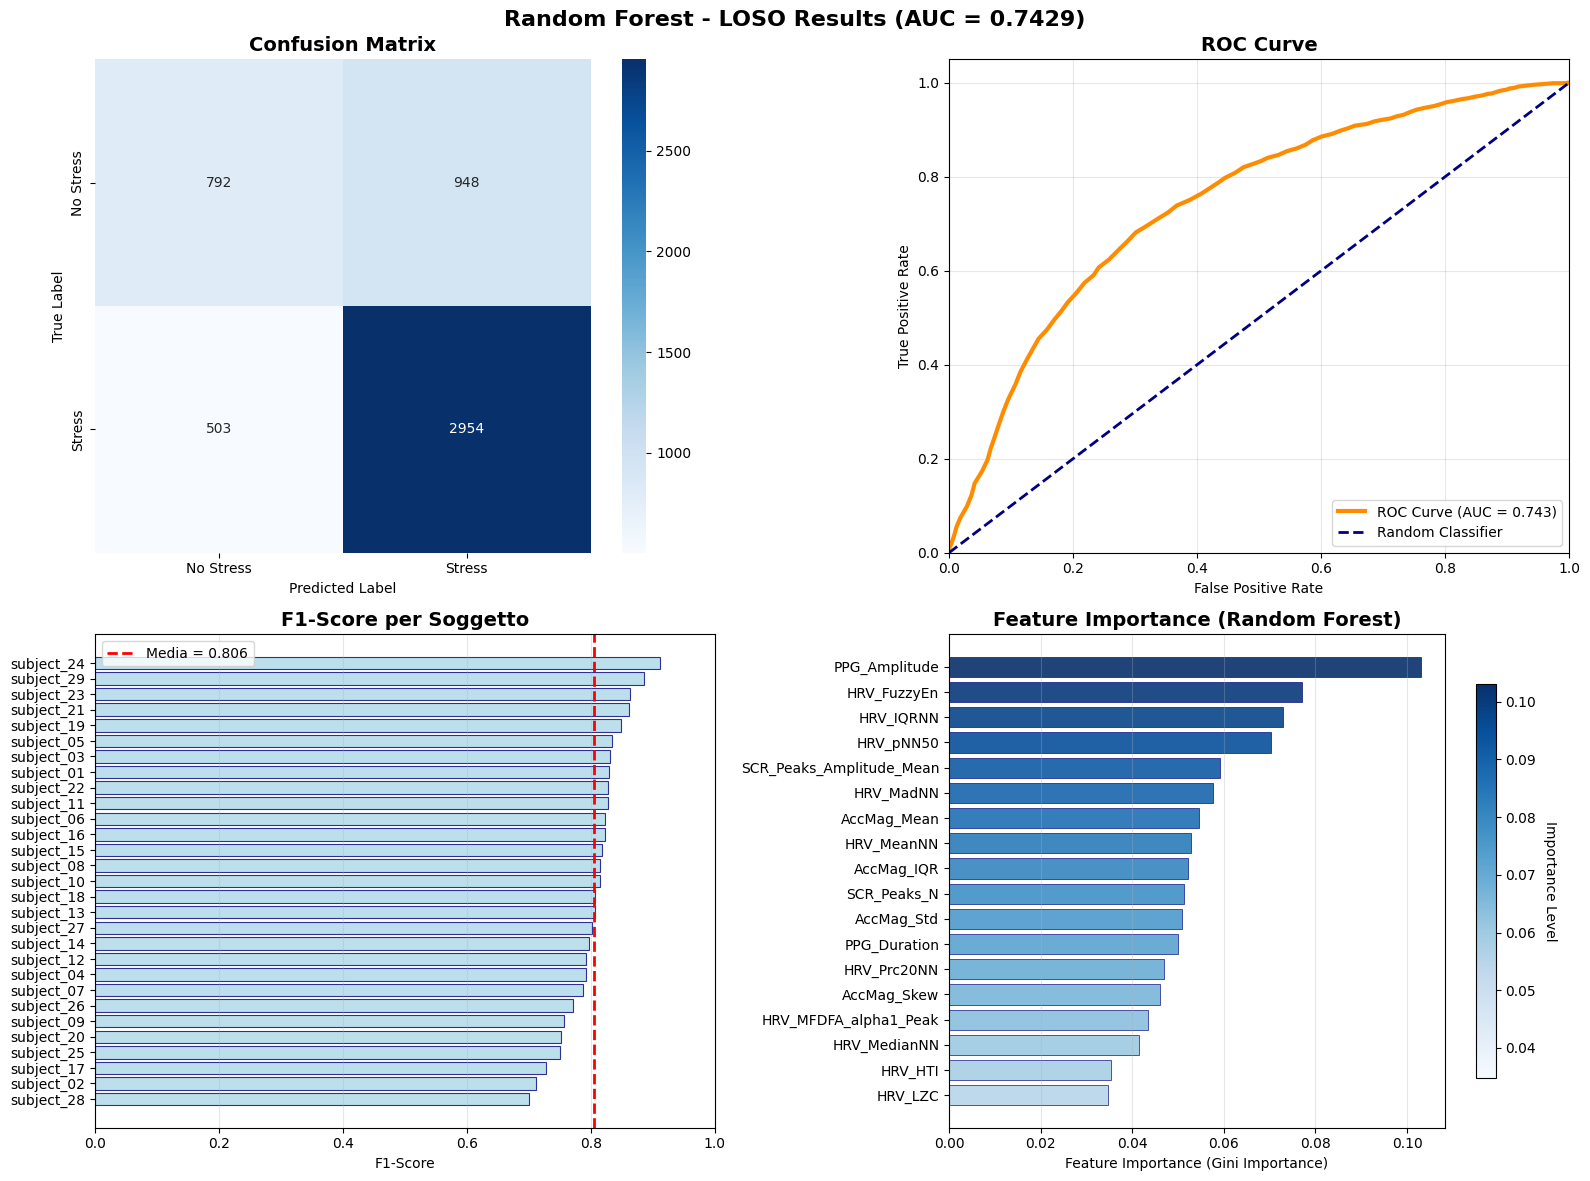


SUMMARY RANDOM FOREST LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8058 ± 0.0486
AUC globale: 0.7429
Accuratezza globale: 0.7208
Range F1-Score: 0.7008 - 0.9115
Miglior soggetto: subject_24 (F1=0.9115)
Peggiore soggetto: subject_28 (F1=0.7008)

Parametri Random Forest:
N. estimatori: 100
Profondità massima: None
Features per split: sqrt
Criterio: gini


In [ ]:
# =============================================================================
# LOSO RANDOM FOREST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO RANDOM FOREST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Model training
    model = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1  # Parallelizzazione per velocità
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_rf = np.array(all_y_true).copy()
all_y_pred_rf = np.array(all_y_pred).copy()
all_y_prob_rf = np.array(all_y_prob).copy()
fpr_rf, tpr_rf, _ = roc_curve(all_y_true_rf, all_y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

f1_mean_rf = results_df['f1_score'].mean()
f1_std_rf = results_df['f1_score'].std()
acc_mean_rf = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Random Forest - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Random Forest Importance
if final_model is not None:
    # Calcola feature importance dal Random Forest
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gini Importance)')
    axes[1,1].set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY RANDOM FOREST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Random Forest:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Features per split: {final_model.max_features}")
    print(f"Criterio: {final_model.criterion}")

print(f"{'='*60}")

GRADIENT BOOSTING CLASSIFIER

=== LOSO GRADIENT BOOSTING ===
Samples: 5197, Features: 18, Subjects: 29

Inizio valutazione LOSO:
  Fold  1 - subject_01: F1=0.844 Acc=0.740
  Fold  2 - subject_02: F1=0.753 Acc=0.617
  Fold  3 - subject_03: F1=0.831 Acc=0.792
  Fold  4 - subject_04: F1=0.815 Acc=0.731
  Fold  5 - subject_05: F1=0.841 Acc=0.792
  Fold  6 - subject_06: F1=0.806 Acc=0.686
  Fold  7 - subject_07: F1=0.771 Acc=0.632
  Fold  8 - subject_08: F1=0.799 Acc=0.681
  Fold  9 - subject_09: F1=0.805 Acc=0.754
  Fold 10 - subject_10: F1=0.774 Acc=0.643
  Fold 11 - subject_11: F1=0.824 Acc=0.798
  Fold 12 - subject_12: F1=0.792 Acc=0.698
  Fold 13 - subject_13: F1=0.835 Acc=0.767
  Fold 14 - subject_14: F1=0.796 Acc=0.728
  Fold 15 - subject_15: F1=0.798 Acc=0.753
  Fold 16 - subject_16: F1=0.774 Acc=0.675
  Fold 17 - subject_17: F1=0.685 Acc=0.582
  Fold 18 - subject_18: F1=0.805 Acc=0.716
  Fold 19 - subject_19: F1=0.862 Acc=0.797
  Fold 20 - subject_20: F1=0.755 Acc=0.688
  Fold 21 - subject_21: F1=0.869 Acc=0.81

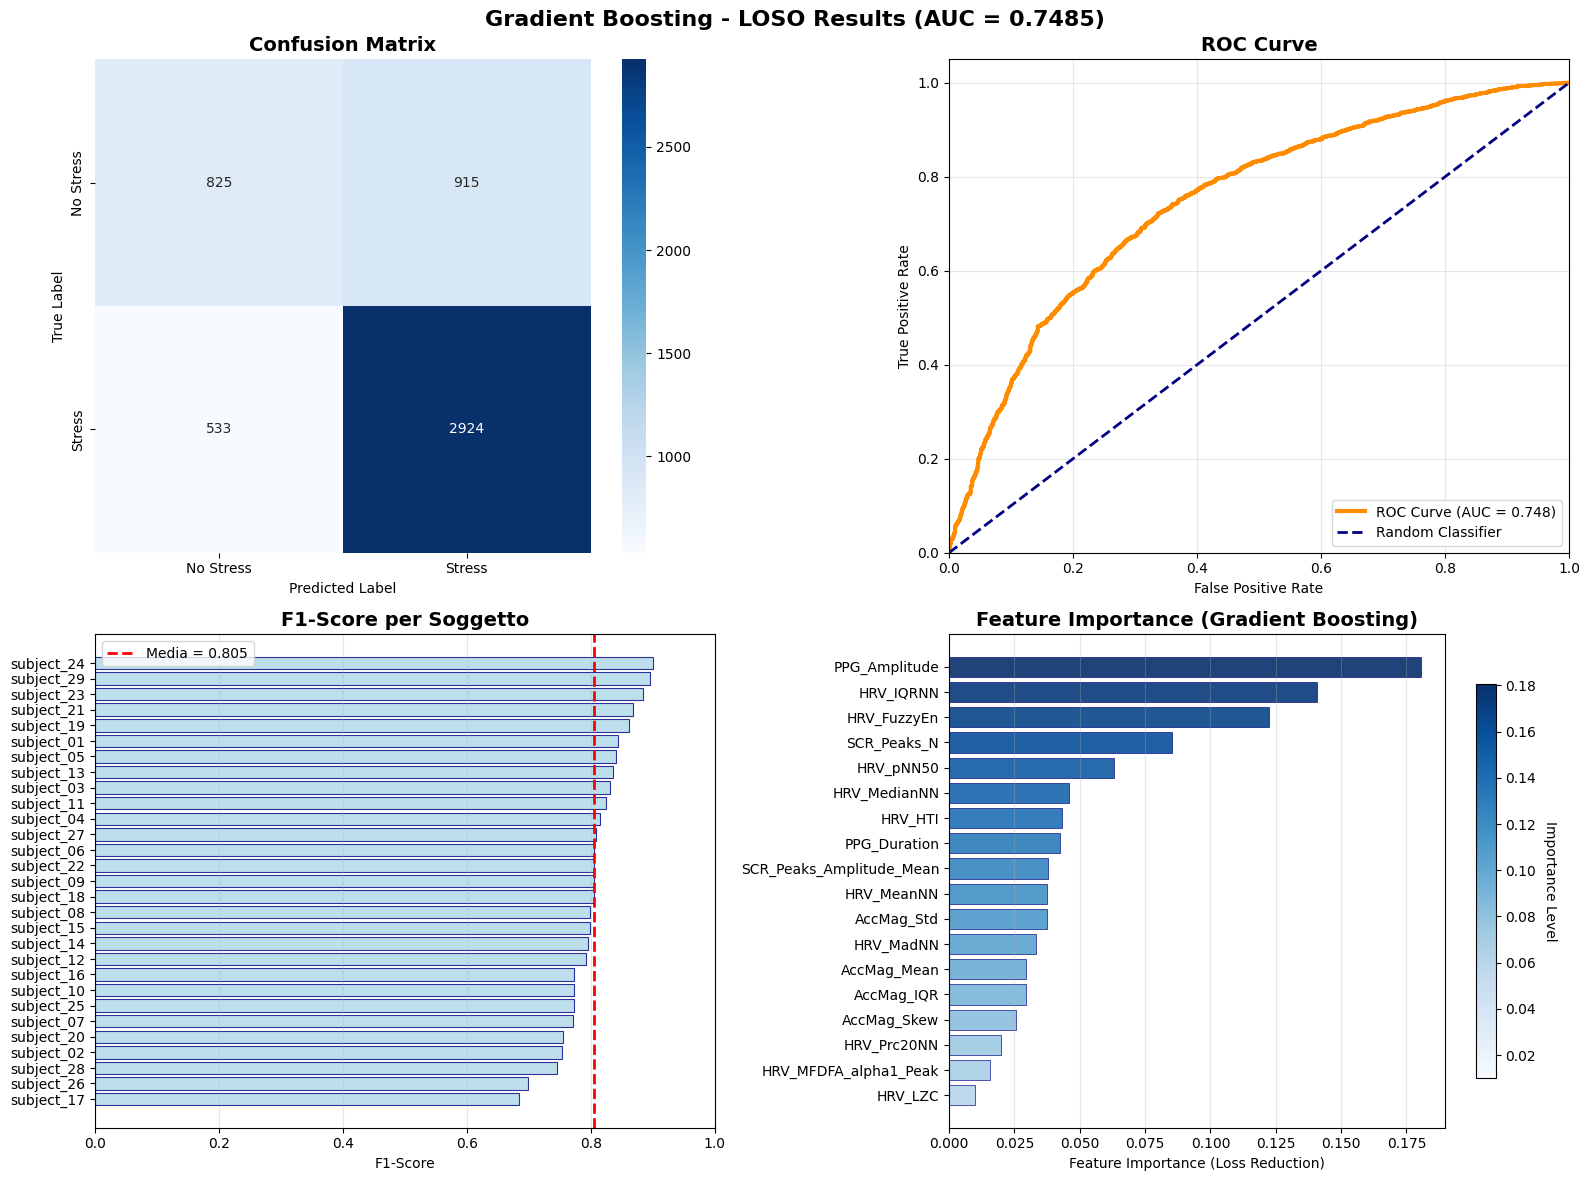


SUMMARY GRADIENT BOOSTING LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8050 ± 0.0516
AUC globale: 0.7485
Accuratezza globale: 0.7214
Range F1-Score: 0.6846 - 0.9004
Miglior soggetto: subject_24 (F1=0.9004)
Peggiore soggetto: subject_17 (F1=0.6846)

Parametri Gradient Boosting:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
N. estimatori effettivi: 87
Training score finale: 0.8549


In [ ]:
# =============================================================================
# LOSO GRADIENT BOOSTING CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO GRADIENT BOOSTING ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (importante per Gradient Boosting)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        max_features='sqrt',
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=5,
        tol=1e-4
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_gb = np.array(all_y_true).copy()
all_y_pred_gb = np.array(all_y_pred).copy()
all_y_prob_gb = np.array(all_y_prob).copy()
fpr_gb, tpr_gb, _ = roc_curve(all_y_true_gb, all_y_prob_gb)
auc_gb = auc(fpr_gb, tpr_gb)

f1_mean_gb = results_df['f1_score'].mean()
f1_std_gb = results_df['f1_score'].std()
acc_mean_gb = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Gradient Boosting - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Gradient Boosting Importance
if final_model is not None:
    # Calcola feature importance dal Gradient Boosting
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Loss Reduction)')
    axes[1,1].set_title('Feature Importance (Gradient Boosting)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY GRADIENT BOOSTING LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Gradient Boosting:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"N. estimatori effettivi: {final_model.n_estimators_}")

    # Informazioni training
    if hasattr(final_model, 'train_score_'):
        print(f"Training score finale: {final_model.train_score_[-1]:.4f}")
    if hasattr(final_model, 'validation_scores_'):
        print(f"Validation score finale: {final_model.validation_scores_[-1]:.4f}")

print(f"{'='*60}")

XGB CLASSIFIER

=== LOSO XGBOOST ===
Samples: 5197, Features: 18, Subjects: 29

Inizio valutazione LOSO:
  Fold  1 - subject_01: F1=0.849 Acc=0.750
  Fold  2 - subject_02: F1=0.753 Acc=0.617
  Fold  3 - subject_03: F1=0.831 Acc=0.792
  Fold  4 - subject_04: F1=0.831 Acc=0.760
  Fold  5 - subject_05: F1=0.852 Acc=0.803
  Fold  6 - subject_06: F1=0.806 Acc=0.686
  Fold  7 - subject_07: F1=0.789 Acc=0.655
  Fold  8 - subject_08: F1=0.812 Acc=0.703
  Fold  9 - subject_09: F1=0.771 Acc=0.705
  Fold 10 - subject_10: F1=0.793 Acc=0.676
  Fold 11 - subject_11: F1=0.836 Acc=0.809
  Fold 12 - subject_12: F1=0.786 Acc=0.692
  Fold 13 - subject_13: F1=0.833 Acc=0.773
  Fold 14 - subject_14: F1=0.784 Acc=0.718
  Fold 15 - subject_15: F1=0.825 Acc=0.774
  Fold 16 - subject_16: F1=0.798 Acc=0.704
  Fold 17 - subject_17: F1=0.627 Acc=0.520
  Fold 18 - subject_18: F1=0.817 Acc=0.740
  Fold 19 - subject_19: F1=0.859 Acc=0.791
  Fold 20 - subject_20: F1=0.748 Acc=0.676
  Fold 21 - subject_21: F1=0.850 Acc=0.790
  Fold 2

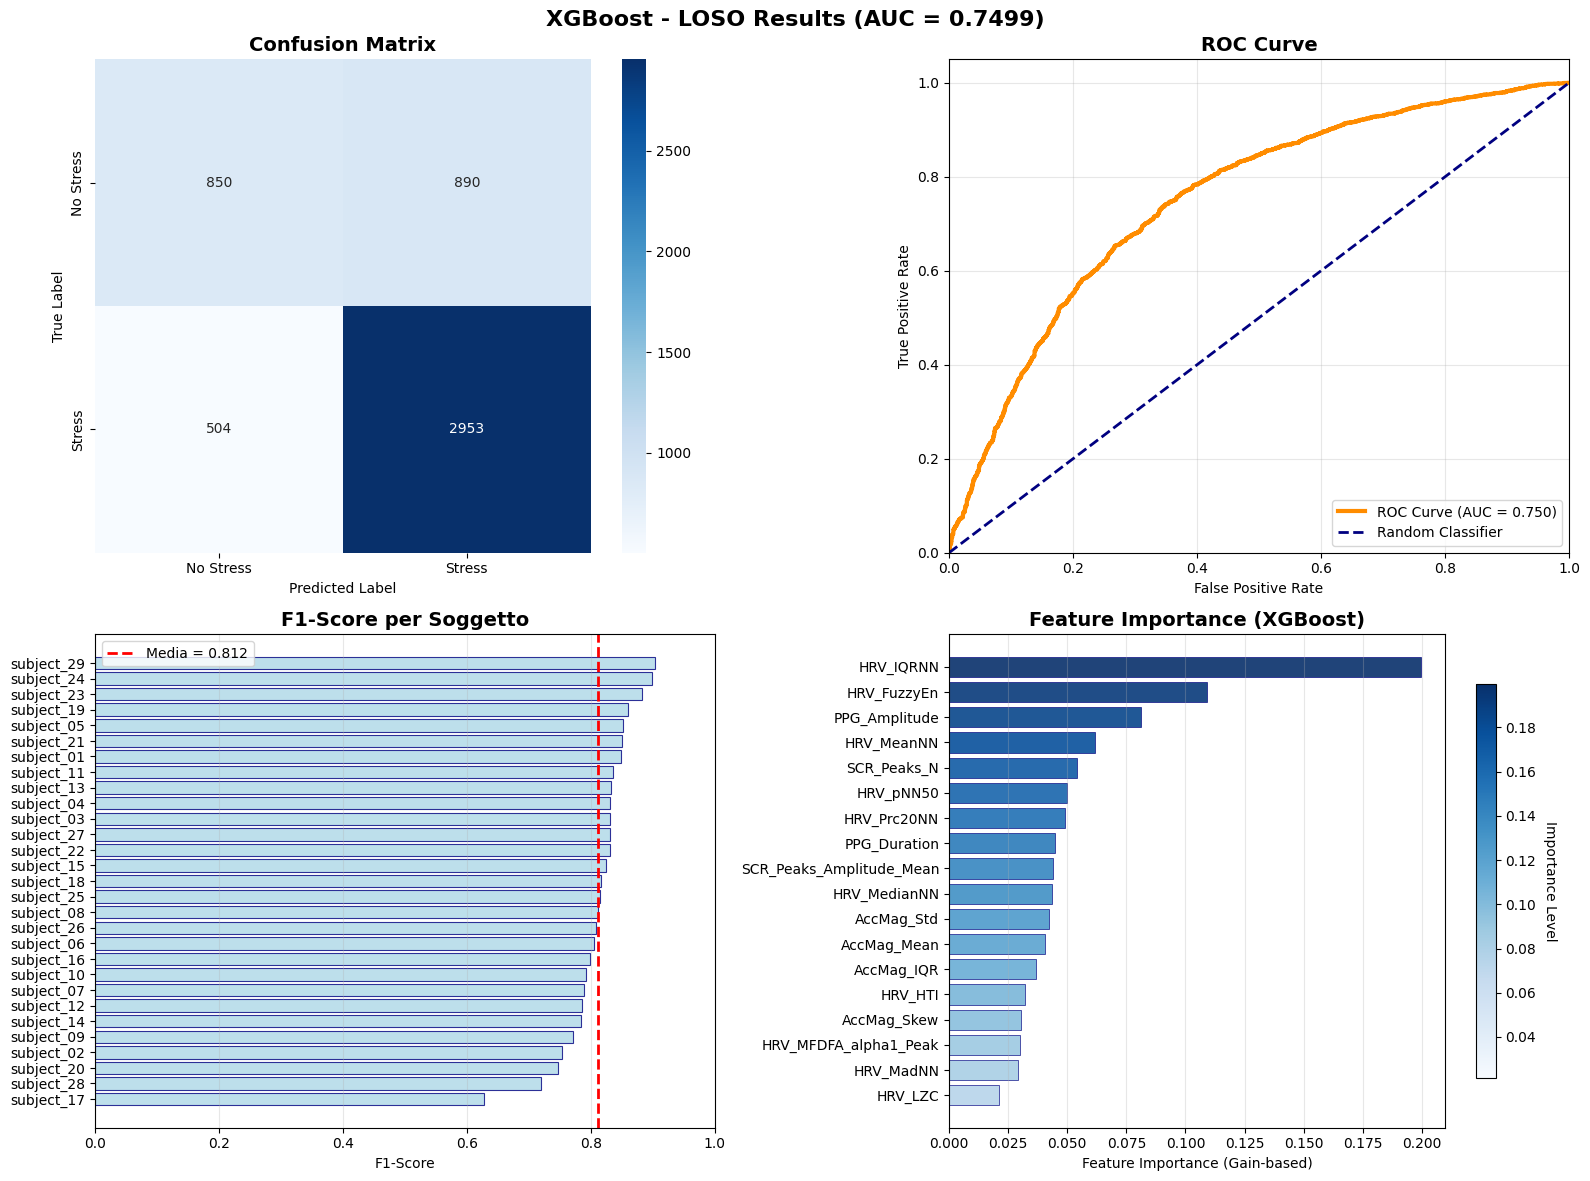


SUMMARY XGBOOST LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8117 ± 0.0550
AUC globale: 0.7499
Accuratezza globale: 0.7318
Range F1-Score: 0.6270 - 0.9037
Miglior soggetto: subject_29 (F1=0.9037)
Peggiore soggetto: subject_17 (F1=0.6270)

Parametri XGBoost:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
Colsample bytree: 0.8
Obiettivo: binary:logistic
Booster: None


In [ ]:
# =============================================================================
# LOSO XGBOOST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO XGBOOST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (XGBoost può beneficiare dello scaling)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_xgb = np.array(all_y_true).copy()
all_y_pred_xgb = np.array(all_y_pred).copy()
all_y_prob_xgb = np.array(all_y_prob).copy()
fpr_xgb, tpr_xgb, _ = roc_curve(all_y_true_xgb, all_y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

f1_mean_xgb = results_df['f1_score'].mean()
f1_std_xgb = results_df['f1_score'].std()
acc_mean_xgb = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'XGBoost - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - XGBoost Importance
if final_model is not None:
    # XGBoost ha diversi tipi di importance, usiamo 'weight' (numero di split)
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gain-based)')
    axes[1,1].set_title('Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

    # Informazioni aggiuntive XGBoost specifiche
    try:
        # Prova ad ottenere diversi tipi di importance
        importance_types = ['weight', 'gain', 'cover']
        print(f"\nTipi di importance XGBoost disponibili:")
        booster = final_model.get_booster()
        for imp_type in importance_types:
            try:
                importance_dict = booster.get_score(importance_type=imp_type)
                if importance_dict:
                    max_feature = max(importance_dict, key=importance_dict.get)
                    print(f"  {imp_type}: {max_feature} = {importance_dict[max_feature]:.4f}")
            except:
                continue
    except:
        pass

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY XGBOOST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello XGBoost
if final_model is not None:
    print(f"\nParametri XGBoost:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"Colsample bytree: {final_model.colsample_bytree}")

    # Informazioni training specifiche XGBoost
    try:
        print(f"Obiettivo: {final_model.objective}")
        print(f"Booster: {final_model.booster}")
    except:
        pass

print(f"{'='*60}")

SVM CLASSIFIER

=== LOSO SVM ===
Samples: 5197, Features: 18, Subjects: 29

Inizio valutazione LOSO:
  Fold  1 - subject_01: F1=0.756 Acc=0.630
  Fold  2 - subject_02: F1=0.684 Acc=0.549
  Fold  3 - subject_03: F1=0.833 Acc=0.810
  Fold  4 - subject_04: F1=0.812 Acc=0.743
  Fold  5 - subject_05: F1=0.840 Acc=0.815
  Fold  6 - subject_06: F1=0.870 Acc=0.806
  Fold  7 - subject_07: F1=0.783 Acc=0.655
  Fold  8 - subject_08: F1=0.773 Acc=0.654
  Fold  9 - subject_09: F1=0.787 Acc=0.749
  Fold 10 - subject_10: F1=0.797 Acc=0.687
  Fold 11 - subject_11: F1=0.753 Acc=0.734
  Fold 12 - subject_12: F1=0.772 Acc=0.692
  Fold 13 - subject_13: F1=0.818 Acc=0.767
  Fold 14 - subject_14: F1=0.772 Acc=0.714
  Fold 15 - subject_15: F1=0.732 Acc=0.704
  Fold 16 - subject_16: F1=0.807 Acc=0.728
  Fold 17 - subject_17: F1=0.684 Acc=0.566
  Fold 18 - subject_18: F1=0.825 Acc=0.763
  Fold 19 - subject_19: F1=0.864 Acc=0.814
  Fold 20 - subject_20: F1=0.683 Acc=0.624
  Fold 21 - subject_21: F1=0.784 Acc=0.716
  Fold 22 - 

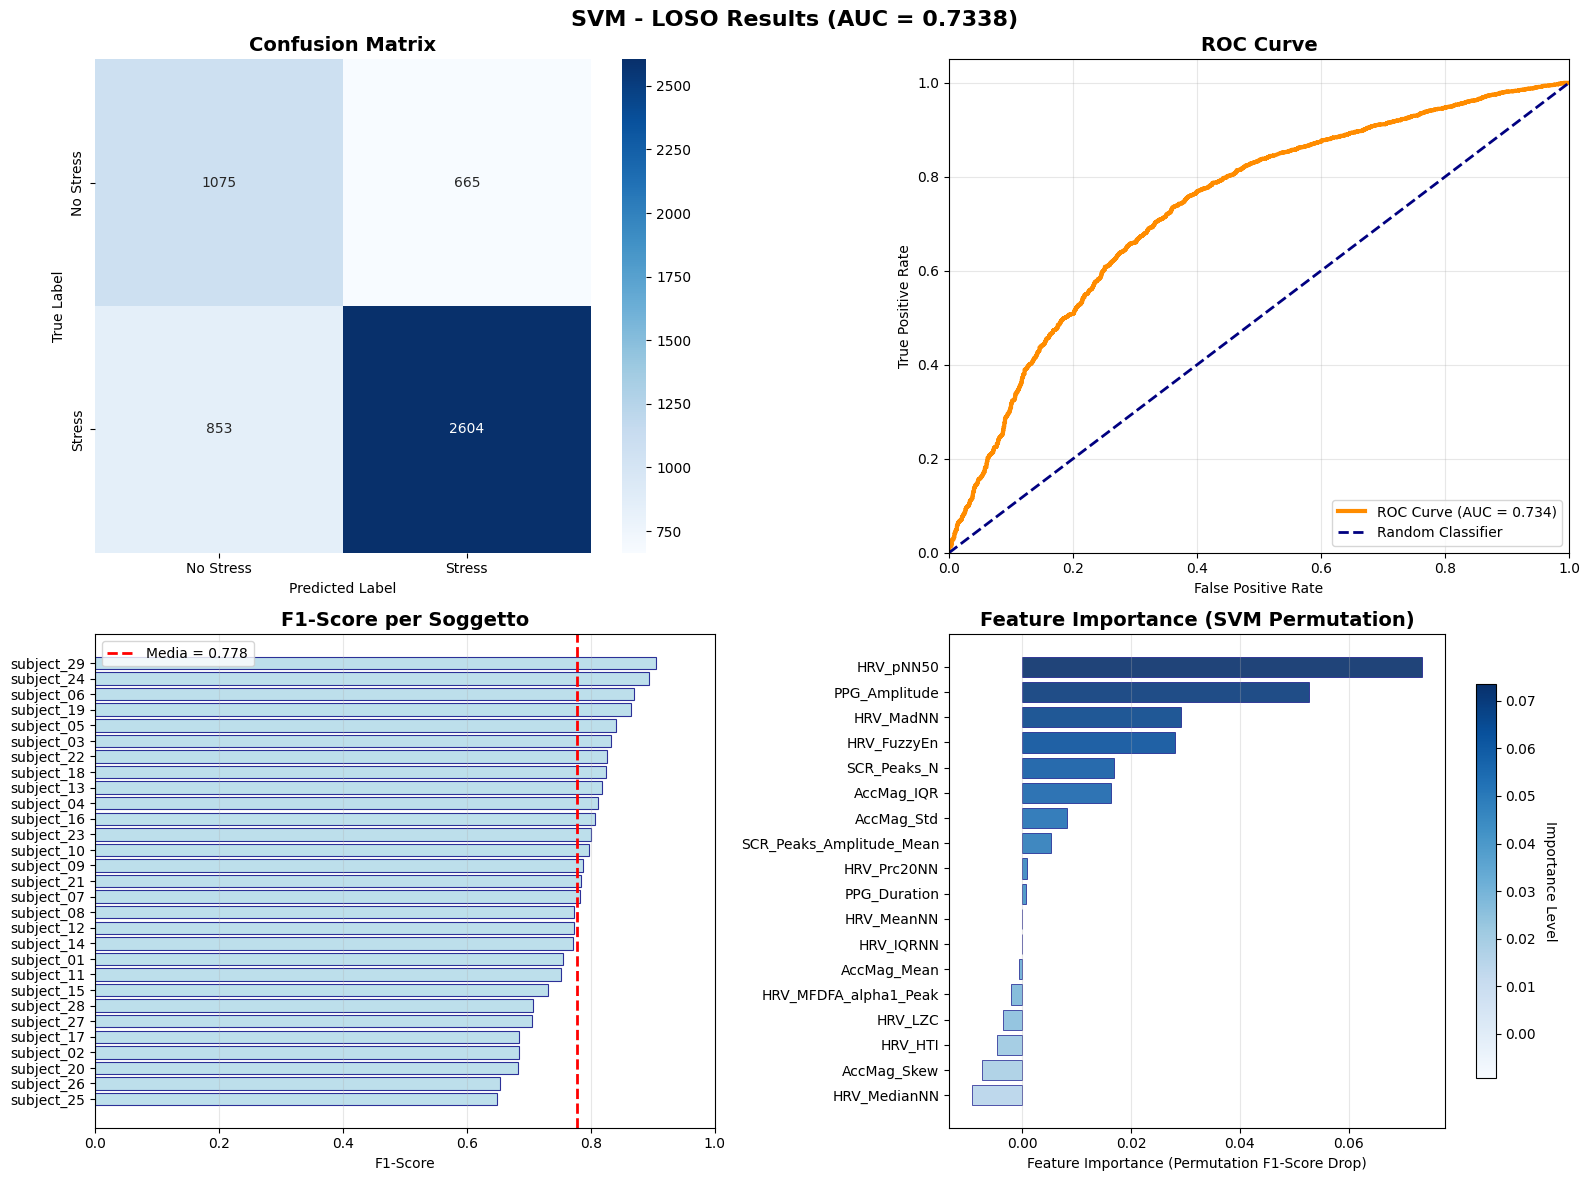


SUMMARY SVM LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.7782 ± 0.0691
AUC globale: 0.7338
Accuratezza globale: 0.7079
Range F1-Score: 0.6491 - 0.9048
Miglior soggetto: subject_29 (F1=0.9048)
Peggiore soggetto: subject_25 (F1=0.6491)

Parametri SVM:
Kernel: rbf
C (regularization): 1.0
Gamma: scale
Class weight: balanced
N. support vectors: [1175 2301]
N. support vectors per classe: {np.int64(0): np.int32(1175), np.int64(1): np.int32(2301)}
Ratio support vectors: 3995.40%


In [ ]:
# =============================================================================
# LOSO SVM CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO SVM ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None
final_X_test = None  # Per calcolo permutation importance
final_y_test = None

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per SVM)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Necessario per predict_proba
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model and test data for feature importance
    final_model = model
    final_X_test = X_test_scaled
    final_y_test = y_test

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_svm = np.array(all_y_true).copy()
all_y_pred_svm = np.array(all_y_pred).copy()
all_y_prob_svm = np.array(all_y_prob).copy()
fpr_svm, tpr_svm, _ = roc_curve(all_y_true_svm, all_y_prob_svm)
auc_svm = auc(fpr_svm, tpr_svm)

f1_mean_svm = results_df['f1_score'].mean()
f1_std_svm = results_df['f1_score'].std()
acc_mean_svm = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'SVM - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - SVM Permutation Importance
if final_model is not None and final_X_test is not None:
    print("Calcolo permutation importance per SVM...")

    try:
        # Calcola permutation importance (unico metodo disponibile per SVM)
        perm_importance = permutation_importance(
            final_model, final_X_test, final_y_test,
            n_repeats=10, random_state=42, scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (SVM Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed',
                       ha='center', va='center', fontsize=12,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY SVM LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello SVM
if final_model is not None:
    print(f"\nParametri SVM:")
    print(f"Kernel: {final_model.kernel}")
    print(f"C (regularization): {final_model.C}")
    print(f"Gamma: {final_model.gamma}")
    print(f"Class weight: {final_model.class_weight}")

    # Informazioni sui support vectors
    print(f"N. support vectors: {final_model.n_support_}")
    print(f"N. support vectors per classe: {dict(zip(final_model.classes_, final_model.n_support_))}")
    if final_X_test is not None:
        support_vector_ratio = final_model.support_vectors_.shape[0] / len(final_X_test)
        print(f"Ratio support vectors: {support_vector_ratio:.2%}")

print(f"{'='*60}")

MLP CLASSIFIER TEST #1

=== LOSO MLP ===
Samples: 5197, Features: 18, Subjects: 29

Inizio valutazione LOSO:
  Fold  1 - subject_01: F1=0.820 Acc=0.712 (12ep)
  Fold  2 - subject_02: F1=0.790 Acc=0.653 (7ep)
  Fold  3 - subject_03: 

F1=0.839 Acc=0.804 (10ep)
  Fold  4 - subject_04: 

F1=0.836 Acc=0.754 (8ep)
  Fold  5 - subject_05: F1=0.829 Acc=0.792 (16ep)
  Fold  6 - subject_06: F1=0.801 Acc=0.680 (9ep)
  Fold  7 - subject_07: F1=0.783 Acc=0.644 (8ep)
  Fold  8 - subject_08: F1=0.809 Acc=0.692 (7ep)
  Fold  9 - subject_09: F1=0.785 Acc=0.721 (9ep)
  Fold 10 - subject_10: F1=0.804 Acc=0.703 (20ep)
  Fold 11 - subject_11: F1=0.859 Acc=0.832 (12ep)
  Fold 12 - subject_12: F1=0.791 Acc=0.709 (17ep)
  Fold 13 - subject_13: F1=0.833 Acc=0.773 (13ep)
  Fold 14 - subject_14: F1=0.818 Acc=0.746 (9ep)
  Fold 15 - subject_15: F1=0.868 Acc=0.812 (11ep)
  Fold 16 - subject_16: F1=0.826 Acc=0.751 (19ep)
  Fold 17 - subject_17: F1=0.816 Acc=0.689 (6ep)
  Fold 18 - subject_18: F1=0.816 Acc=0.734 (11ep)
  Fold 19 - subject_19: F1=0.858 Acc=0.797 (14ep)
  Fold 20 - subject_20: F1=0.740 Acc=0.671 (11ep)
  Fold 21 - subject_21: F1=0.802 Acc=0.722 (15ep)
  Fold 22 - subject_22: F1=0.827 Acc=0.778 (15ep)
  Fold 23 - subject_23: F1=0.828 Acc=0.778 (20ep)
  Fold 24 - subject_24: F1=0.88

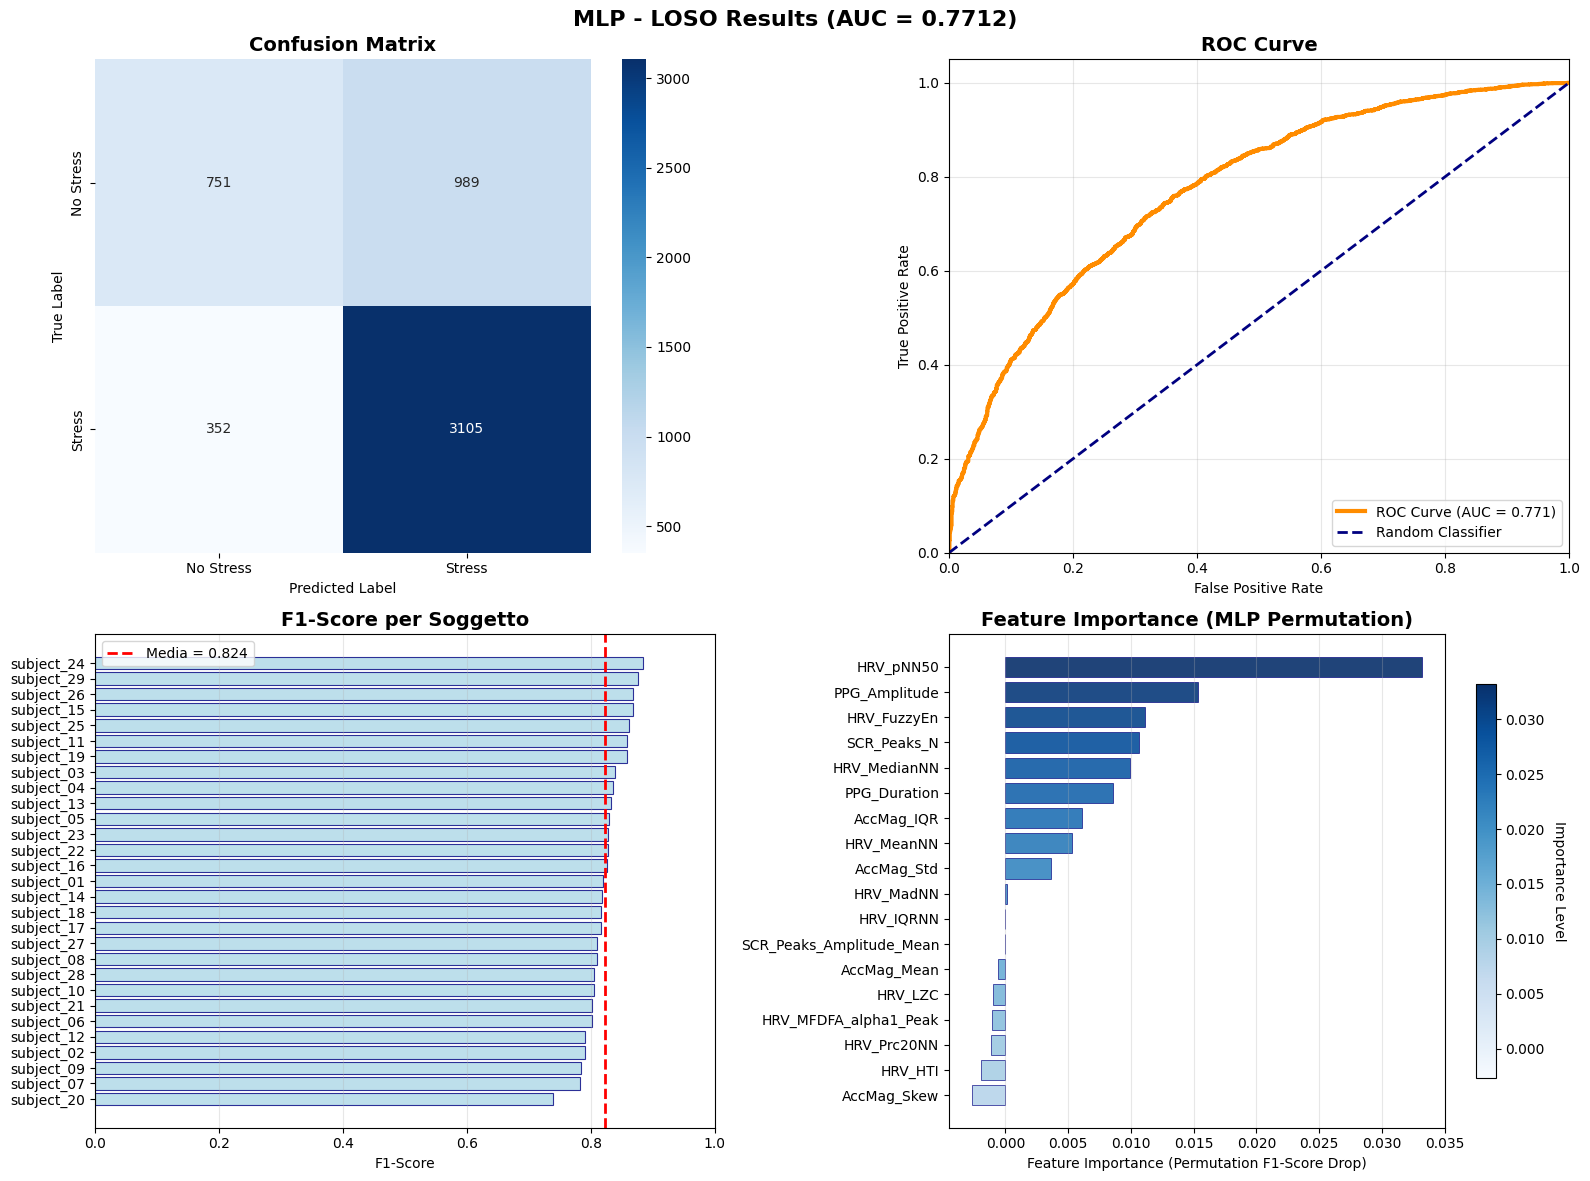


SUMMARY MLP LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8236 ± 0.0324
AUC globale: 0.7712
Accuratezza globale: 0.7420
Range F1-Score: 0.7397 - 0.8839
Miglior soggetto: subject_24 (F1=0.8839)
Peggiore soggetto: subject_20 (F1=0.7397)
Epoche medie utilizzate: 12.2
Early stopping attivato: 29 / 29 fold


In [ ]:
# =============================================================================
# LOSO MLP CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE MODELLO MLP
# =============================================================================

def build_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))

    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO MLP ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance
final_scaler = None

print("\nInizio valutazione LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per reti neurali)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Costruisci modello
    model = build_mlp_model(X_train_scaled.shape[1])

    # Callback per early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_prob = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    epochs_used = len(history.history['loss'])
    print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep)")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'epochs_used': epochs_used
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Keep final model for feature importance
    final_model = tf.keras.models.clone_model(model)
    final_model.set_weights(model.get_weights())
    final_scaler = scaler

    # Pulizia memoria
    del model, history
    tf.keras.backend.clear_session()

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
print(f"Epoche medie:    {results_df['epochs_used'].mean():.1f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

all_y_true_mlp = np.array(all_y_true).copy()
all_y_pred_mlp = np.array(all_y_pred).copy()
all_y_prob_mlp = np.array(all_y_prob).copy()
fpr_mlp, tpr_mlp, _ = roc_curve(all_y_true_mlp, all_y_prob_mlp)
auc_mlp = auc(fpr_mlp, tpr_mlp)

f1_mean_mlp = results_df['f1_score'].mean()
f1_std_mlp = results_df['f1_score'].std()
acc_mean_mlp = results_df['accuracy'].mean()

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'MLP - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - MLP Permutation Importance
if final_model is not None:
    print("Calcolo permutation importance per MLP...")

    try:
        # Prepara dati per permutation importance
        # Usa un subset rappresentativo per velocità
        sample_size = min(500, len(all_y_true))
        sample_indices = np.random.choice(len(all_y_true), sample_size, replace=False)

        X_sample = np.array([X[i] for i in sample_indices])
        y_sample = np.array([all_y_true[i] for i in sample_indices])

        # Normalizza con final_scaler
        X_sample_scaled = final_scaler.transform(X_sample)

        # Wrapper class per sklearn compatibility
        class MLPWrapper:
            def __init__(self, model):
                self.model = model

            def fit(self, X, y):
                return self  # Dummy fit

            def predict(self, X):
                return (self.model.predict(X, verbose=0) > 0.5).astype(int).flatten()

            def score(self, X, y):
                y_pred = self.predict(X)
                return f1_score(y, y_pred, zero_division=0)

        # Crea wrapper
        mlp_wrapper = MLPWrapper(final_model)

        # Calcola permutation importance
        perm_importance = permutation_importance(
            mlp_wrapper, X_sample_scaled, y_sample,
            n_repeats=5,  # Ridotto per velocità
            random_state=42,
            scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (MLP Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed\n(Computationally expensive)',
                       ha='center', va='center', fontsize=11,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY MLP LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject_result = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject_result = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject_result} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject_result} (F1={results_df['f1_score'].min():.4f})")

# Informazioni training
print(f"Epoche medie utilizzate: {results_df['epochs_used'].mean():.1f}")
print(f"Early stopping attivato: {np.sum(results_df['epochs_used'] < 30)} / {len(results_df)} fold")

print(f"{'='*60}")


CONFRONTO CURVE ROC - TUTTI I MODELLI ML/DL SU DATASET CAMPANELLA
[OK] Logistic Regression       - Risultati disponibili
[OK] Random Forest             - Risultati disponibili
[OK] Gradient Boosting         - Risultati disponibili
[OK] XGBoost                   - Risultati disponibili
[OK] SVM                       - Risultati disponibili
[OK] MLP                       - Risultati disponibili

[OK] Proseguo con il confronto di 6 modelli



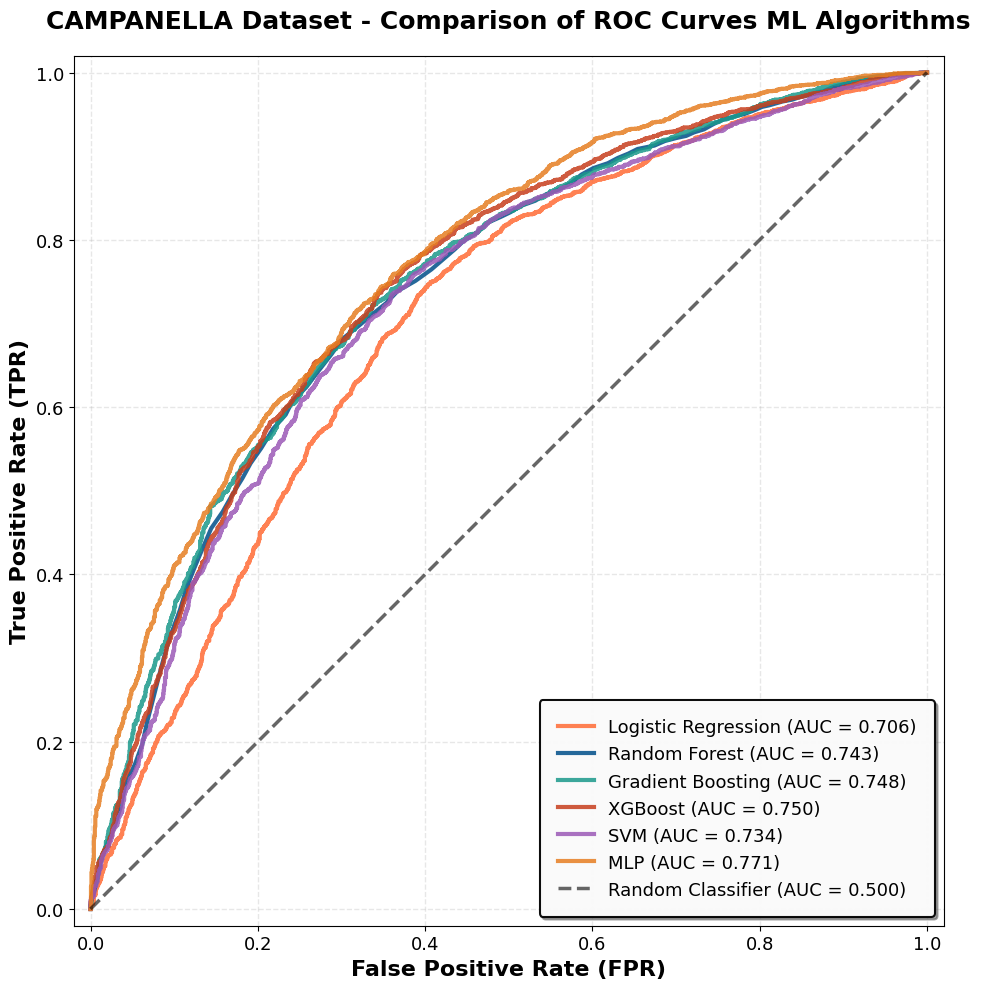


TABELLA RIASSUNTIVA - AUC SCORE PER MODELLO

 Rank             Modello    AUC
    1                 MLP 0.7712
    2             XGBoost 0.7499
    3   Gradient Boosting 0.7485
    4       Random Forest 0.7429
    5                 SVM 0.7338
    6 Logistic Regression 0.7058


MIGLIOR MODELLO: MLP
AUC Score: 0.7712

STATISTICHE AUC SU 6 MODELLI:
Media:    0.7420
Mediana:  0.7457
Std Dev:  0.0216
Range:    [0.7058, 0.7712]
Gap:      0.0654

RANKING FINALE:
   1. MLP                       - AUC: 0.7712
   2. XGBoost                   - AUC: 0.7499
   3. Gradient Boosting         - AUC: 0.7485
   4. Random Forest             - AUC: 0.7429
   5. SVM                       - AUC: 0.7338
   6. Logistic Regression       - AUC: 0.7058

GAP ANALYSIS:
   Gap 1-2: 0.0213 (2.13%)
   Gap 2-3: 0.0015 (0.15%)
   Gap 3-4: 0.0056 (0.56%)

CATEGORIZZAZIONE PERFORMANCE:
   Fair (0.7 <= AUC < 0.8): 6 modelli
      - MLP (AUC = 0.7712)
      - XGBoost (AUC = 0.7499)
      - Gradient Boosting (AUC = 0.7485)

In [ ]:
# =============================================================================
# CONFRONTO CURVE ROC - TUTTI I MODELLI ML/DL
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import pandas as pd

print("\n" + "="*80)
print("CONFRONTO CURVE ROC - TUTTI I MODELLI ML/DL SU DATASET CAMPANELLA")
print("="*80)

# =============================================================================
# VERIFICA DISPONIBILITA RISULTATI
# =============================================================================

required_vars = {
    'Logistic Regression': ('fpr_lr', 'tpr_lr', 'auc_lr'),
    'Random Forest': ('fpr_rf', 'tpr_rf', 'auc_rf'),
    'Gradient Boosting': ('fpr_gb', 'tpr_gb', 'auc_gb'),
    'XGBoost': ('fpr_xgb', 'tpr_xgb', 'auc_xgb'),
    'SVM': ('fpr_svm', 'tpr_svm', 'auc_svm'),
    'MLP': ('fpr_mlp', 'tpr_mlp', 'auc_mlp')
}

available_models = []
missing_models = []

for model_name, (fpr_var, tpr_var, auc_var) in required_vars.items():
    if fpr_var in globals() and tpr_var in globals() and auc_var in globals():
        available_models.append(model_name)
        print(f"[OK] {model_name:25s} - Risultati disponibili")
    else:
        missing_models.append(model_name)
        print(f"[NO] {model_name:25s} - Risultati NON disponibili")

if missing_models:
    print(f"\n[WARNING] {len(missing_models)} modelli mancanti!")
    print("          Esegui prima le sezioni LOSO di tutti i modelli.")

if len(available_models) < 2:
    print("\n[ERROR] Servono almeno 2 modelli per il confronto!")
else:
    print(f"\n[OK] Proseguo con il confronto di {len(available_models)} modelli\n")

    # =============================================================================
    # PLOT: CURVE ROC SOVRAPPOSTE (FIGURA QUADRATA)
    # =============================================================================

    fig, ax = plt.subplots(figsize=(10, 10))

    # Definisci configurazione per ogni modello
    models_config = [
        ('Logistic Regression', fpr_lr if 'fpr_lr' in globals() else None,
         tpr_lr if 'tpr_lr' in globals() else None,
         auc_lr if 'auc_lr' in globals() else None, '#FF6B35'),
        ('Random Forest', fpr_rf if 'fpr_rf' in globals() else None,
         tpr_rf if 'tpr_rf' in globals() else None,
         auc_rf if 'auc_rf' in globals() else None, '#004E89'),
        ('Gradient Boosting', fpr_gb if 'fpr_gb' in globals() else None,
         tpr_gb if 'tpr_gb' in globals() else None,
         auc_gb if 'auc_gb' in globals() else None, '#1B998B'),
        ('XGBoost', fpr_xgb if 'fpr_xgb' in globals() else None,
         tpr_xgb if 'tpr_xgb' in globals() else None,
         auc_xgb if 'auc_xgb' in globals() else None, '#C73E1D'),
        ('SVM', fpr_svm if 'fpr_svm' in globals() else None,
         tpr_svm if 'tpr_svm' in globals() else None,
         auc_svm if 'auc_svm' in globals() else None, '#9B59B6'),
        ('MLP', fpr_mlp if 'fpr_mlp' in globals() else None,
         tpr_mlp if 'tpr_mlp' in globals() else None,
         auc_mlp if 'auc_mlp' in globals() else None, '#E67E22')
    ]

    # Plot curve ROC per ogni modello disponibile
    for model_name, fpr, tpr, auc_score, color in models_config:
        if fpr is not None and tpr is not None and auc_score is not None:
            ax.plot(fpr, tpr,
                    color=color,
                    linewidth=3,
                    alpha=0.85,
                    label=f'{model_name} (AUC = {auc_score:.3f})')

    # Plot linea random classifier
    ax.plot([0, 1], [0, 1],
            'k--',
            linewidth=2.5,
            label='Random Classifier (AUC = 0.500)',
            alpha=0.6)

    # Configurazione assi e titolo
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=16, fontweight='bold')
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=16, fontweight='bold')
    ax.set_title('CAMPANELLA Dataset - Comparison of ROC Curves ML Algorithms',
                 fontsize=18, fontweight='bold', pad=20)

    # Grid e limiti
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_aspect('equal')

    # Legenda con box shadow
    legend = ax.legend(loc='lower right',
                      fontsize=13,
                      framealpha=0.95,
                      shadow=True,
                      fancybox=True,
                      borderpad=1)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)

    # Tick più grandi
    ax.tick_params(labelsize=13)

    # Layout e visualizzazione
    plt.tight_layout()
    plt.show()

    # =============================================================================
    # TABELLA RIASSUNTIVA
    # =============================================================================

    print("\n" + "="*80)
    print("TABELLA RIASSUNTIVA - AUC SCORE PER MODELLO")
    print("="*80 + "\n")

    # Raccogli dati AUC disponibili
    comparison_data = []
    if 'auc_lr' in globals():
        comparison_data.append({'Modello': 'Logistic Regression', 'AUC': auc_lr})
    if 'auc_rf' in globals():
        comparison_data.append({'Modello': 'Random Forest', 'AUC': auc_rf})
    if 'auc_gb' in globals():
        comparison_data.append({'Modello': 'Gradient Boosting', 'AUC': auc_gb})
    if 'auc_xgb' in globals():
        comparison_data.append({'Modello': 'XGBoost', 'AUC': auc_xgb})
    if 'auc_svm' in globals():
        comparison_data.append({'Modello': 'SVM', 'AUC': auc_svm})
    if 'auc_mlp' in globals():
        comparison_data.append({'Modello': 'MLP', 'AUC': auc_mlp})

    # Crea DataFrame e ordina per AUC
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('AUC', ascending=False).reset_index(drop=True)
    comparison_df['Rank'] = range(1, len(comparison_df) + 1)

    # Stampa tabella
    print(comparison_df[['Rank', 'Modello', 'AUC']].to_string(
        index=False,
        float_format=lambda x: f'{x:.4f}'))
    print("\n" + "="*80)

    # Identifica miglior modello
    best_model = comparison_df.iloc[0]
    print(f"\nMIGLIOR MODELLO: {best_model['Modello']}")
    print(f"AUC Score: {best_model['AUC']:.4f}")

    # Statistiche aggregate
    print(f"\nSTATISTICHE AUC SU {len(comparison_df)} MODELLI:")
    print(f"Media:    {comparison_df['AUC'].mean():.4f}")
    print(f"Mediana:  {comparison_df['AUC'].median():.4f}")
    print(f"Std Dev:  {comparison_df['AUC'].std():.4f}")
    print(f"Range:    [{comparison_df['AUC'].min():.4f}, {comparison_df['AUC'].max():.4f}]")
    print(f"Gap:      {comparison_df['AUC'].max() - comparison_df['AUC'].min():.4f}")

    # Ranking
    print(f"\nRANKING FINALE:")
    for idx, row in comparison_df.iterrows():
        print(f"   {idx+1}. {row['Modello']:25s} - AUC: {row['AUC']:.4f}")

    # Gap analysis
    if len(comparison_df) >= 2:
        print(f"\nGAP ANALYSIS:")
        for i in range(min(3, len(comparison_df) - 1)):
            gap = comparison_df.iloc[i]['AUC'] - comparison_df.iloc[i+1]['AUC']
            print(f"   Gap {i+1}-{i+2}: {gap:.4f} ({gap*100:.2f}%)")

    # Categorizzazione performance
    print(f"\nCATEGORIZZAZIONE PERFORMANCE:")
    excellent = comparison_df[comparison_df['AUC'] >= 0.9]
    good = comparison_df[(comparison_df['AUC'] >= 0.8) & (comparison_df['AUC'] < 0.9)]
    fair = comparison_df[(comparison_df['AUC'] >= 0.7) & (comparison_df['AUC'] < 0.8)]
    poor = comparison_df[comparison_df['AUC'] < 0.7]

    if len(excellent) > 0:
        print(f"   Excellent (AUC >= 0.9): {len(excellent)} modelli")
        for _, row in excellent.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    if len(good) > 0:
        print(f"   Good (0.8 <= AUC < 0.9): {len(good)} modelli")
        for _, row in good.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    if len(fair) > 0:
        print(f"   Fair (0.7 <= AUC < 0.8): {len(fair)} modelli")
        for _, row in fair.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    if len(poor) > 0:
        print(f"   Poor (AUC < 0.7): {len(poor)} modelli")
        for _, row in poor.iterrows():
            print(f"      - {row['Modello']} (AUC = {row['AUC']:.4f})")

    print("\n" + "="*80)
    print("ANALISI COMPARATIVA COMPLETATA")
    print("="*80 + "\n")